# Determining the shape of a pendant drop by the shooting method
#### Tan Beng Hau, Cavitation Lab

In this notebook the shape of the pendant drop is worked out using the Young-Laplace equation. Since a number of variables are not known beforehand, we need to carry out an iterative search for the correct solution. This problem was first calculated by Bashforth and Adams, who painstakingly created tables to cover a wide range of parameters. These days, computers can do the hard work in a split second. 

There are a number of ways to solve the Bashforth-Adams problem, most of which ends up with a system of 2 or 3 ordinary differential equations to be solved simultaneously. I am aware of a description in Pozrikidis but I found that one to be rather difficult to follow. I found the following formulation much easier to understand. 

## The curvature of a function $y=f(x)$

In this section I will briefly describe how to determine the curvature of a Cartesian function. The arc length $s$ of a curved segment can be expressed in various ways: for instance, in the standard Cartesian $(x,y)$ coordinates,

$$ ds = \sqrt{1 + \frac{dy}{dx}}dx. $$

We can also write it as $ds = R d\theta$, where $R$ is the radius of curvature and $\theta$ is an angular displacement. The curvature is defined as $\kappa \equiv 1/R$. We can convert from $\theta$ to Cartesian coordinates using $\theta = \arctan (dy/dx)$. Taking the derivative,

$$ \frac{d\theta}{dx} = \frac{d^2 y/dx^2}{1 + (dy/dx)^2}. $$

A change of variables then gives 

$$ \kappa = \frac{d\theta}{ds} = \frac{d\theta}{dx} \frac{dx}{ds} = \frac{d^2 y / dx^2}{(1 + dy/dx)^{3/2}}. $$

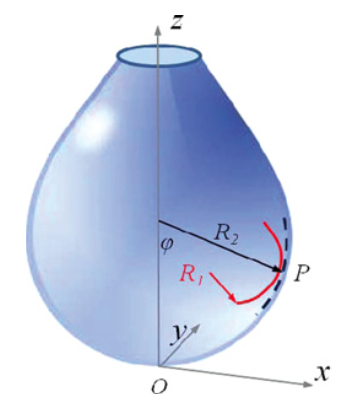

In [20]:
from IPython.display import Image
Image(filename='pendant.png')

## Hydrostatic equations for a pendant drop

A pendant drop is a three dimensional object -- meaning that it has two radii of curvature. Let the point $P$ lie on the surface of the drop. If we draw a line normal to $P$ and extend it to the axis of symmetry (the $y$-axis) of the drop, the angle subtended between the $y$-axis and the normal line is $\phi$. Since $\tan \phi = dy/dx $,  we may write 

$$\sin\phi = \frac{dy/dx}{\sqrt{1+(dy/dx)^2}}.$$

We have two radii of curvature. To derive the first one, we note from geometry that $ ds = R_1 d\phi$,

and hence

$$ \frac{1}{R_1} = \frac{d^2 y / dx^2}{(1 + dy/dx)^{3/2}} $$

Again, from geometrical conditions, we have $ x = R_2 \sin \phi $, and this leads to the other radius of curvature 

$$ \frac{1}{R_2} = \frac{dy/dx}{x\sqrt{1+(dy/dx)^2}} $$

In this formulation we should also note that 

$$ dx = ds \cos \phi, $$

$$ dy = ds \sin \phi. $$

If we measure all quantities from the base of the drop (ie $y=0$ at the base), then at the apex 

$$ \gamma \left( \frac{1}{R_1} + \frac{1}{R_2} \right) = \Delta \rho g y +  \frac{2\gamma}{b},$$

where $b = R_1 = R_2$ is the vertical distance from the top to the bottom of the drop. 

Since $R_1$ and $R_2$ are already functions of $(x,y)$, one might think that we could solve the equations purely in $x,y$. Why would we need the variables $s,\phi$? The problem actually lies in the boundary conditions: we simply can't express the boundary condition in our numerical solution, and that necessitates a change of coordinates.

Once the transformations are complete we have the system of equations

$$ \frac{d\phi}{ds} = \frac{\rho g}{\gamma}y + \frac{2}{b} - \frac{\sin\phi}{x},$$

$$ \frac{dx}{ds} = \cos\phi, $$

$$ \frac{dy}{ds} = \sin\phi. $$

The integration starts from the side opposite the plate (ie, the apex) where we define $x=0, y=0, s=0$. We stop integrating at the contact angle between the plate and the drop. Since one of the radii of curvature of our pendant drop, $R_1$, is just the curvature in the $xy$ projection, and we know that the maximum value of $R_1$ is $b$, we just have to integrate from $s=0$ to $s = \int_0^\alpha R_1 d\theta = \alpha b$.


## Solving a system of equations

We use in-built solvers in Scipy/Matlab to simultaneously solve a system of multiple ODEs. Our job is just to write them in the form

$$ \frac{d}{ds}\begin{bmatrix} x \\ y \\ \phi \end{bmatrix} = \begin{bmatrix} 0 && 0 &&0 \\ 0 && 0 && 0  \\ 0 && \rho g/\gamma && 0 \end{bmatrix} \begin{bmatrix} x \\ y \\ \phi \end{bmatrix}+ \begin{bmatrix} \cos\phi \\ \sin\phi \\ 2b  - \sin\phi \end{bmatrix}. $$

## Solution scheme

For this calculation let us say that we want the drop area to be $A_D$. The calculation will then proceed as follows.

1. First, we work out the drop profile using an initial guess for $B$. 

2. We calculate the contact area in the suggested solution. Is it exactly $A_D$? It probably will not be...

3. ... so adjust $B$ and repeat steps 1-2 until the contact area is what we want.

A smart way to do this adjustment is with the Nelder-Mead (`fmin` in Scipy and `fminsearch` in Matlab) algorithm. Here, we are trying to find the zero (minimum) of the objective function

$$ Q = 2\int_0^d x dy - A_D,$$

where $d$ describes the position of the plane, $A_D$ is the target area we want and the integral is directly calculated from each guess of the drop profile. It will work, provided our guess is sufficiently good.

In practice, we might want to find the drop profile of a certain volume $V$ of liquid that we have dispensed. In that case we will work out the volume of revolution about the axis of symmetry (that being the $y$-axis) and the objective function will then be

$$ Q = \int_0^d \pi x^2 dy - V_D. $$

In [1]:
from __future__ import division
from scipy import *
from scipy.integrate import odeint
from scipy.optimize import fmin
import matplotlib.pyplot as plt
%matplotlib inline

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 28


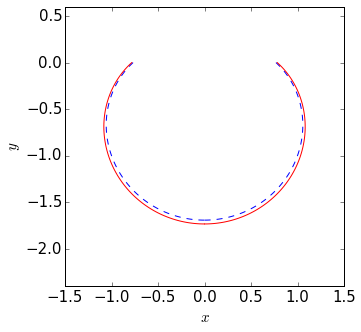

In [19]:
# The objective function
def objective(b):
    B = b
    y0 = [1e-6,1e-6,1e-6]
    t = linspace(0, alpha*b, 100)    
    soln = odeint(f, y0, t, args=(b,))
    return abs(targetArea - 2*trapz(abs(soln[:,0]), abs(soln[:,1]) ))

# Solve the system of equations f(z,t)
# ... where z =[x, y, phi]
def f(z,t,B):
    x = z[0]
    y = z[1]
    phi = z[2]
    f0 = cos(phi)
    f1 = sin(phi)
    f2 = +(rho*g/gamma)*y + 2/B - sin(phi)/x
    return [f0, f1, f2]
        

def plotProfile(rho, g, gamma, alpha, targetArea, profileType):
        
    if profileType == 'sessile': 
        g = -abs(g)
    elif profileType == 'pendant':
        g = +abs(g)
        
    # initial guess
    a = sqrt(2*targetArea / (2*alpha - sin(2*alpha))) 
    y0 = [1e-6,1e-6,1e-6]
        
    # Solve the original guess
    t = linspace(0, alpha*a, 100) 
    B = a
    oldsoln = odeint(f, y0, t, args=(a,))
    
    newB = fmin(objective, a, xtol=1e-8)
    t = linspace(0, alpha*newB, 100) 
    B = newB
    soln = odeint(f, y0, t, args=(newB,))
    
    if profileType == 'pendant':
        plt.figure(figsize=(5,5))
        plt.axis('equal')
        plt.plot(oldsoln[:,0]/1e-3, oldsoln[:,1]/1e-3 -max(oldsoln[:,1])/1e-3, 'b--')
        plt.plot(-oldsoln[:,0]/1e-3, oldsoln[:,1]/1e-3-max(oldsoln[:,1])/1e-3, 'b--')
        plt.plot(soln[:,0]/1e-3, soln[:,1]/1e-3 -max(soln[:,1])/1e-3, 'r')
        plt.plot(-soln[:,0]/1e-3, soln[:,1]/1e-3-max(soln[:,1])/1e-3, 'r')
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.rcParams['font.size'] = '15'
        
    elif profileType == 'sessile':
        plt.figure(figsize=(5,5))
        plt.axis('equal')
        plt.plot(oldsoln[:,0]/1e-3, -oldsoln[:,1]/1e-3  +max(oldsoln[:,1])/1e-3, 'b--')
        plt.plot(-oldsoln[:,0]/1e-3, -oldsoln[:,1]/1e-3 +max(oldsoln[:,1])/1e-3, 'b--')
        plt.plot(soln[:,0]/1e-3, -soln[:,1]/1e-3  +max(soln[:,1])/1e-3, 'r')
        plt.plot(-soln[:,0]/1e-3, -soln[:,1]/1e-3 +max(soln[:,1])/1e-3, 'r')
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.rcParams['font.size'] = '15'

rho = 1e3
g = 9.81
gamma = 72e-3
alpha = 1.4*pi/2
targetArea = pi*1e-3*1e-3
profileType = 'pendant'
plotProfile(rho, g, gamma, alpha, targetArea, profileType)